In [1]:
import torch
from mlp import make_dataset, Linear, BatchNormalization1D, Tanh, Embedding, WavenetFlatten, Sequential
import matplotlib.pyplot as plt
from torch.optim import AdamW
from pathlib import Path
from torch.nn.functional import cross_entropy
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.functional import F
%matplotlib inline

In [2]:
names_file = Path("./names.txt")
context_window = 8
X , Y, itos = make_dataset(names_file, context_window=context_window)

In [3]:
train_X, eval_X, train_Y, eval_Y = train_test_split(X,Y,test_size=0.2)
val_X, test_X, val_Y, test_Y = train_test_split(eval_X,eval_Y,test_size=0.5)

In [4]:
for x,y in zip(train_X[0:20], train_Y[0:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()]) 

....rutl --> e
........ --> d
...miken --> .
........ --> m
..juneau --> .
.......d --> a
........ --> j
.......r --> a
.....cam --> a
.......e --> d
.......s --> t
...rylen --> d
aryaveer --> .
...neysa --> .
....asha --> y
..itzaya --> n
........ --> p
....erde --> m
.....niy --> e
...yousr --> a


In [5]:
torch.manual_seed(42);

In [13]:
n_embedding = 10
n_hidden = 200
vocab_size = 27

model = Sequential([
    Embedding(vocab_size,n_embedding),
    WavenetFlatten(2),
    Linear(n_embedding*2, n_hidden),
    BatchNormalization1D(n_hidden),
    Tanh(),
    WavenetFlatten(2),
    Linear(n_hidden*2, n_hidden),
    BatchNormalization1D(n_hidden),
    Tanh(),
    WavenetFlatten(2),
    Linear(n_hidden*2, n_hidden),
    BatchNormalization1D(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
])
    
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

In [14]:
max_steps = 30000
batch_size = 32

train_loss = []

for i in range(max_steps):
    # Minibatch sampling
    random_index = torch.randint(0,train_X.shape[0],(batch_size,))
    
    X_batch = train_X[random_index]
    Y_batch = train_Y[random_index]
    
    logits = model(X_batch)
        
    loss = cross_entropy(logits, Y_batch)
    train_loss.append(loss.item())
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    LR = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -LR * p.grad

Text(0.5, 1.0, 'WaveNet like implementation')

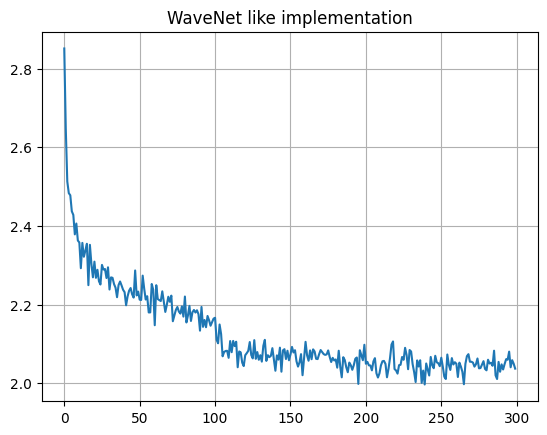

In [17]:
plt.plot(torch.tensor(train_loss).view(-1,100).mean(1))
plt.grid()
plt.title("WaveNet like implementation")